In [1]:
import os
os.getcwd()
os.chdir('/home/a4ankan/aMAZON fINAL WORK/amazon fine food')
os.getcwd()

'/home/a4ankan/aMAZON fINAL WORK/amazon fine food'

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# it connects my code with the sql database
con = sqlite3.connect('database.sqlite') 



#Writting a query; 'con' is the link
# Here, I am saying that 'slelct (*) from reviews which are not equal to 3'.
#Just take the reviews which are 1,2,4 or 5.



filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) #filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3


# here, due to memory issues i am taking only 4000 reviews that i would work with



# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative 0'
    return 'positive 1'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
filtered_data.sort_values('Time',inplace=True) 

print(filtered_data.shape) #The score coloumn becomesb positive / negative
filtered_data.head()

(525814, 10)


Id   ProductId          UserId         ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL     shari zychinski   
138683  150501  0006641040   AJ46FKXOVC7NR  Nicholas A Mesiano   
417839  451856  B00004CXX9   AIUWLEQ1ADEG5    Elizabeth Medina   
417859  451878  B00004CXX9  A344SMIA5JECGM     Vincent P. Ross   
212472  230285  B00004RYGX  A344SMIA5JECGM     Vincent P. Ross   

        HelpfulnessNumerator  HelpfulnessDenominator       Score       Time  \
138706                     0                       0  positive 1  939340800   
138683                     2                       2  positive 1  940809600   
417839                     0                       0  positive 1  944092800   
417859                     1                       2  positive 1  944438400   
212472                     1                       2  positive 1  944438400   

                                                  Summary  \
138706                          EVERY book is educational   
138683  This whole series is great way to spend time w...   
417839                               Entertainingl Funny!   
417859                            A modern day fairy tale   
212472                            A modern day fairy tale   

                                                     Text  
138706  this witty little book makes my son laugh at l...  
138683  I can remember seeing the show when it aired o...  
417839  Beetlejuice is a well written movie ..... ever...  
417859  A twist of rumplestiskin captured on film, sta...  
212472  A twist of rumplestiskin captured on film, sta...

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape



(364173, 10)

In [4]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY Time
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   
1  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       2      4  1212883200   
1                     3                       1      5  1224892800   

                                        Summary  \
0  Pure cocoa taste with crunchy almonds inside   
1             Bought This for My Son at College   

                                                Text  
0  It was almost a 'love at first bite' - the per...  
1  My son loves spaghetti so I didn't hesitate or...

In [8]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]


#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?

(364171, 10)


In [9]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
Summary:  A young boy describes the usefulness of chicken soup with rice for each month of the year.<br /><br />Evaluation:  With Sendak's creative repetitious and rhythmic words, children will enjoy and learn to read the story of a boy who loves chicken soup with rice!  Through Sendak's catchy story, children will also learn the months of the year, as well as what seasons go with what month! They learn to identify ice-skating and snowmen in the winter; strong wind in March; birds and flowers in the spring; swimming and hot temperatures in the summer; and finally different holidays throughout the year. Such as Halloween in October, and Christmas in December.<br /><br />Sendak's simple three colored crayon-like drawings are a perfect addition to his educational and entertaining story.<br /><br />A great activity that you can do with this book is to have children draw their own illustrations for each month of the year.  Afterwards you can bind the pages together so the children can cre

In [10]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'those', 'yourself', 'but', 'most', 'under', "shouldn't", 'couldn', "should've", 'why', 'there', 'for', 'our', "mightn't", 'being', 're', 'having', 'out', 'her', "doesn't", 'before', 'not', 'just', 'him', 've', 'hasn', "you'd", "you've", 'are', 'did', 'hers', 'any', 'other', 'himself', 'themselves', "aren't", 'aren', 'whom', 'both', 'can', 'am', "weren't", "shan't", 'ma', "that'll", 'yourselves', 'don', 'very', 'she', "isn't", 'he', 'few', 'they', 'above', 'won', 'some', 'between', 'too', 'these', 'such', 'how', 'd', 'ain', 'you', 'weren', 'an', "hasn't", 'me', 't', 'their', 'against', 'had', 'in', 'hadn', 'wouldn', 'we', 'and', 'own', 'or', 'again', 'your', 'does', 'y', 'of', "you're", "couldn't", 'mustn', 'myself', 'this', 'through', 'doesn', 'while', 'below', 'the', 'isn', "mustn't", "hadn't", 'on', 'off', 'then', 'itself', "wasn't", 'wasn', 'further', "didn't", 'mightn', 'has', 'if', 'his', 'needn', 'it', 'with', 'into', 'over', 'when', 'each', "haven't", 'i', 'shan', 'no', 'shoul

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [12]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [13]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, 
             chunksize=None, dtype=None)

In [14]:
final.head() #below the processed review can be seen in the CleanedText Column 

Id   ProductId          UserId  \
138706  150524  0006641040   ACITT7DI6IDDL   
138705  150523  0006641040  A2P4F2UO0UMP8C   
138699  150517  0006641040   ABW4IC5G5G8B5   
138680  150498  0006641040  A3SJWISOCP31TR   
138689  150507  0006641040  A1S4A3IQ2MU7V4   

                                  ProfileName  HelpfulnessNumerator  \
138706                        shari zychinski                     0   
138705  Elizabeth A. Curry "Lovely Librarian"                     0   
138699                            kevin clark                     0   
138680                            R. J. Wells                     2   
138689                  sally sue "sally sue"                     1   

        HelpfulnessDenominator       Score        Time  \
138706                       0  positive 1   939340800   
138705                       0  positive 1  1096675200   
138699                       0  positive 1  1291075200   
138680                       2  positive 1  1176336000   
138689                       1  positive 1  1191456000   

                              Summary  \
138706      EVERY book is educational   
138705          MMMM chicken soup....   
138699              good for children   
138680                A Gem of a Book   
138689  chicken soup with rice months   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138705  Summary:  A young boy describes the usefulness...   
138699  Classic children's book, can't go wrong. I rea...   
138680  This is a wonderful little book. I loved it 40...   
138689  This is a fun way for children to learn their ...   

                                              CleanedText  
138706  witti littl book make son laugh loud recit car...  
138705  young boy describ use chicken soup rice month ...  
138699  classic children book cant wrong read kid orde...  
138680  wonder littl book love year ago twin love enjo...  
138689  fun way children learn month year learn poem t...

In [18]:
final = final[0:6250]
final.shape

(6250, 11)

In [19]:
X = final['CleanedText']
X.head()

138706    witti littl book make son laugh loud recit car...
138705    young boy describ use chicken soup rice month ...
138699    classic children book cant wrong read kid orde...
138680    wonder littl book love year ago twin love enjo...
138689    fun way children learn month year learn poem t...
Name: CleanedText, dtype: object

In [20]:
Y = final['Score']

Y.head()

138706    positive 1
138705    positive 1
138699    positive 1
138680    positive 1
138689    positive 1
Name: Score, dtype: object

In [26]:
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import warnings
warnings.filterwarnings("ignore")

In [27]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X,Y, test_size=0.2, random_state=0)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (5000,)
Test Data Size:  (1250,)


In [28]:
from sklearn import preprocessing
from numpy import *
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import scikitplot as skplt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics


#  Bag of Words :

In [29]:
##BoW

X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

count_vect = CountVectorizer() #in scikit-learn
X_train_bow = count_vect.fit_transform(X_train) #
X_test_bow = count_vect.transform(X_test)#

In [30]:
all_feat = count_vect.get_feature_names()

In [33]:
from scipy.sparse import*

In [34]:
A = csr_matrix(X_train_bow)
A

<4375x9925 sparse matrix of type '<class 'numpy.int64'>'
	with 149686 stored elements in Compressed Sparse Row format>

In [35]:
X_train_bow = X_train_bow.toarray()
X_train_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [36]:
from sklearn.cluster import AgglomerativeClustering

In [52]:
for k in range(1, 20):
    model =  AgglomerativeClustering(n_clusters= k + 1, affinity= 'euclidean').fit(X_train_bow)


In [58]:
model.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [59]:
child = model.children_
child

array([[1145, 2515],
       [3954, 4299],
       [ 855, 1779],
       ...,
       [8742, 8744],
       [8728, 8745],
       [8746, 8747]])

In [60]:
terms = count_vect.get_feature_names()


In [56]:
from wordcloud import*


 Cluster 1:



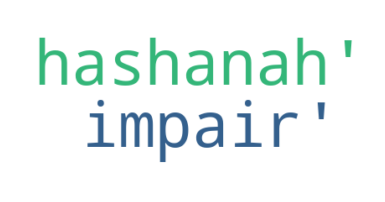


 Cluster 2:



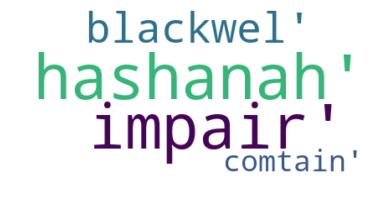


 Cluster 3:



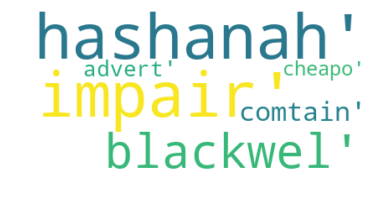


 Cluster 4:



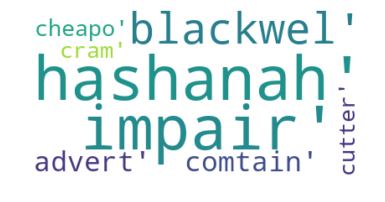


 Cluster 5:



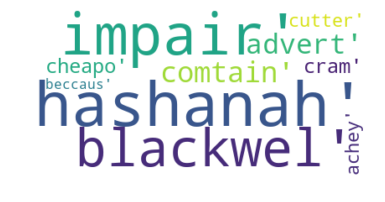


 Cluster 6:



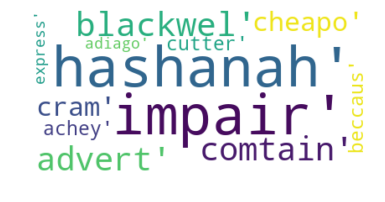


 Cluster 7:



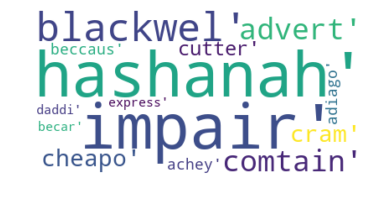


 Cluster 8:



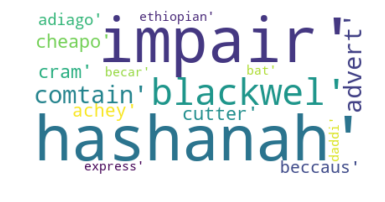


 Cluster 9:



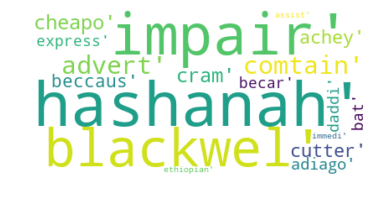


 Cluster 10:



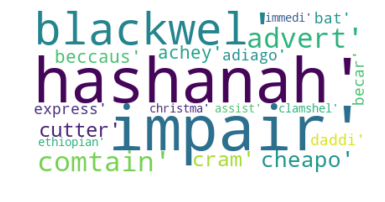


 Cluster 11:



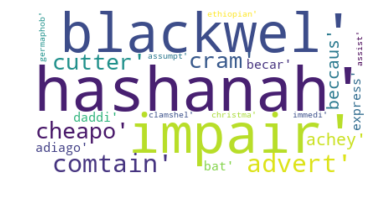


 Cluster 12:



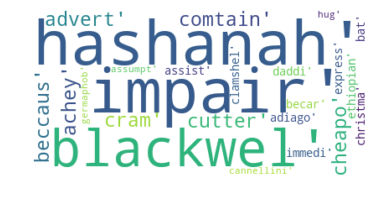


 Cluster 13:



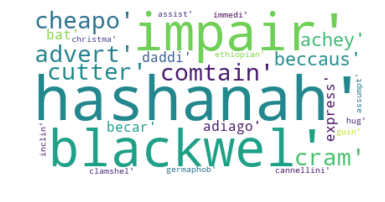


 Cluster 14:



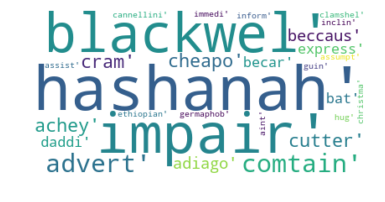


 Cluster 15:



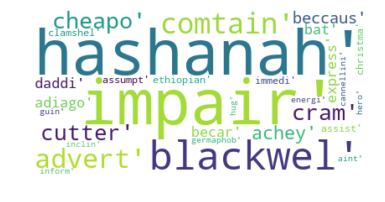


 Cluster 16:



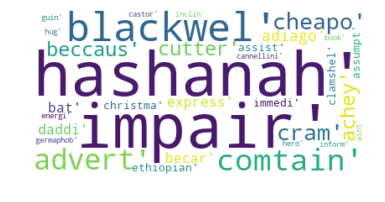


 Cluster 17:



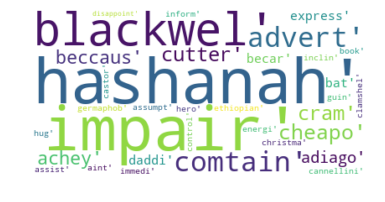


 Cluster 18:



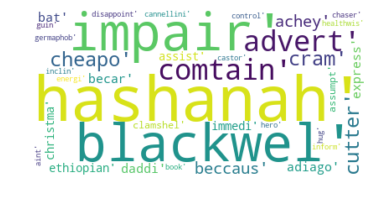


 Cluster 19:



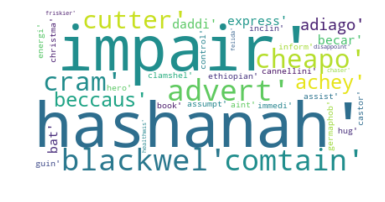

In [61]:
store = []
stop =  set(STOPWORDS)
for i in range(1,20):
    print("\n Cluster %d:\n" % i)
    for j in child[i, :1000]:
        store.append(terms[j])
        #print(' %s' % terms[j]),
    #print
   
    wc = WordCloud(background_color="white", max_words=len(str(store)), stopwords=stop)
    wc.generate(str(store))
   # print("Word Cloud forCluster:", i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


#  Tfidf:

In [62]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), max_features = 25000)
X_train_tf = tf_idf_vect.fit_transform(X_train)

X_test_tf = tf_idf_vect.transform(X_test)

In [70]:
terms = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",terms[20:40])

some sample features(unique words in the corpus) ['abl stand', 'abl tast', 'abl use', 'abnorm', 'abomin', 'abroad', 'absent', 'absolut', 'absolut ador', 'absolut amaz', 'absolut aw', 'absolut best', 'absolut delici', 'absolut favorit', 'absolut hate', 'absolut love', 'absolut noth', 'absolut perfect', 'absolut recommend', 'absolut wonder']


In [65]:
A = csr_matrix(X_train_tf)
A

<4375x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 214650 stored elements in Compressed Sparse Row format>

In [66]:
X_train_tf = X_train_tf.toarray()
X_train_tf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [67]:
for k in range(1, 20):
    model =  AgglomerativeClustering(n_clusters= k, affinity= 'euclidean').fit(X_train_tf)


In [68]:
model.labels_

array([18,  0,  0, ...,  0,  1,  0])

In [69]:
child = model.children_
child

array([[1145, 2515],
       [3954, 4299],
       [  51,  706],
       ...,
       [8703, 8745],
       [8741, 8746],
       [8744, 8747]])


 Cluster 1:



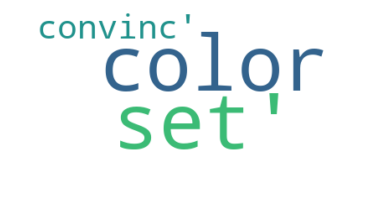


 Cluster 2:



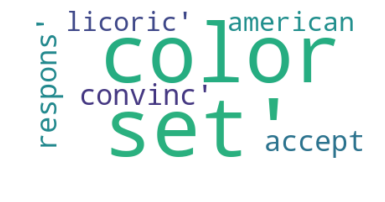


 Cluster 3:



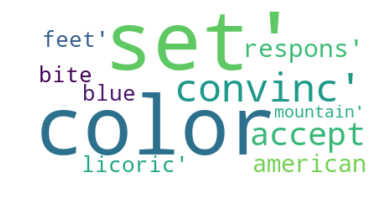


 Cluster 4:



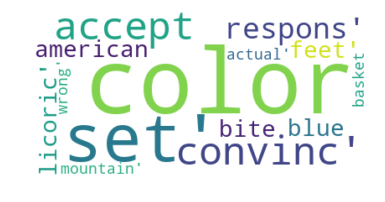


 Cluster 5:



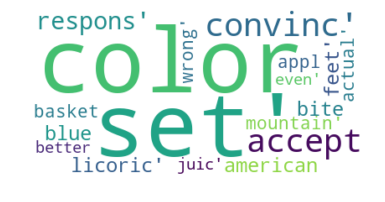


 Cluster 6:



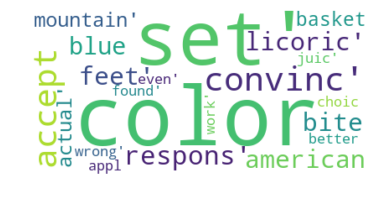


 Cluster 7:



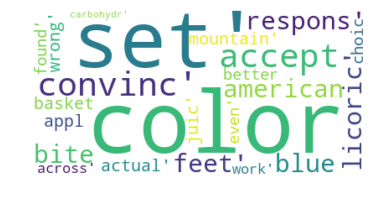


 Cluster 8:



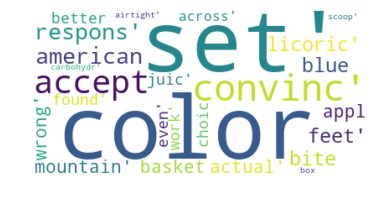


 Cluster 9:



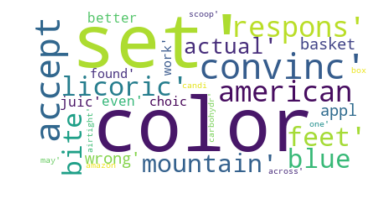


 Cluster 10:



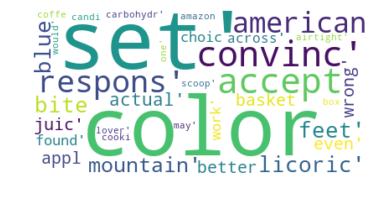


 Cluster 11:



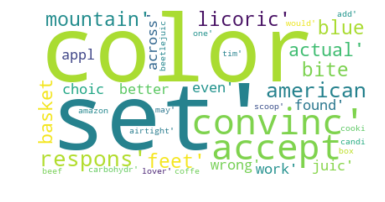


 Cluster 12:



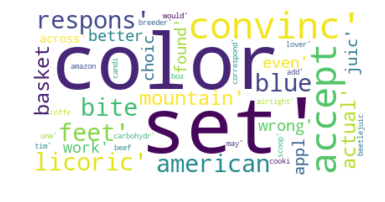


 Cluster 13:



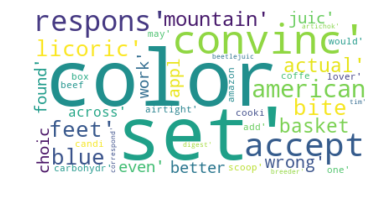


 Cluster 14:



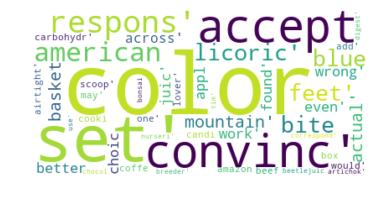


 Cluster 15:



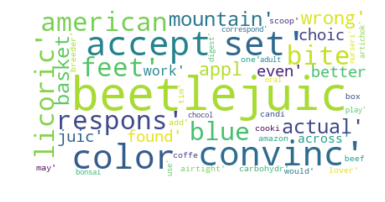


 Cluster 16:



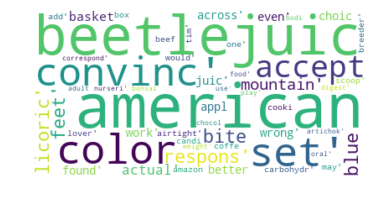


 Cluster 17:



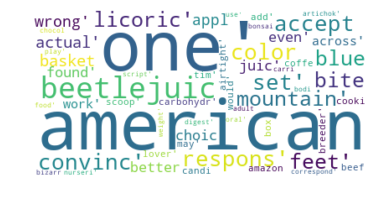


 Cluster 18:



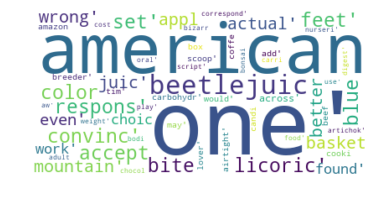


 Cluster 19:



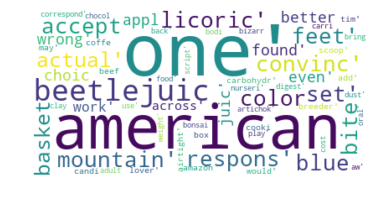

In [71]:
store = []
stop =  set(STOPWORDS)
for i in range(1,20):
    print("\n Cluster %d:\n" % i)
    for j in child[i, :1000]:
        store.append(terms[j])
        #print(' %s' % terms[j]),
    #print
   
    wc = WordCloud(background_color="white", max_words=len(str(store)), stopwords=stop)
    wc.generate(str(store))
   # print("Word Cloud forCluster:", i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


# Word to vec :

In [72]:
from tqdm import tqdm
from sklearn import preprocessing

In [73]:
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

In [77]:
w2v_model = Word2Vec(list_of_sent,min_count=5,size= 100, workers=4)

In [78]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3397
sample words  ['one', 'extra', 'dark', 'chocol', 'tri', 'compar', 'much', 'higher', 'price', 'brand', 'like', 'etc', 'hachez', 'darn', 'good', 'cocoa', 'great', 'creami', 'chai', 'flavor', 'hard', 'find', 'tast', 'caffein', 'free', 'tea', 'fit', 'bill', 'sparkl', 'work', 'well', 'cake', 'decor', 'awar', 'edibl', 'usual', 'use', 'sweet', 'made', 'type', 'candi', 'dont', 'worri', 'theyr', 'bare', 'notic', 'exist', 'pretti', 'tini', 'bottl']


In [152]:
terms = count_vect.get_feature_names() # list of words in the BoW

In [80]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4375/4375 [00:03<00:00, 1450.40it/s]

4375
100


In [124]:
for k in range(1, 20):
    model =  AgglomerativeClustering(n_clusters= k, affinity= 'euclidean').fit(sent_vectors)


In [148]:
model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=19,
            pooling_func=<function mean at 0x7f2adc158598>)

In [151]:
child = model.children_
child

array([[1145, 2515],
       [3954, 4299],
       [1965, 2101],
       ...,
       [8742, 8743],
       [8744, 8746],
       [8745, 8747]])

In [126]:
labels = model.labels_
labels

array([18,  1, 18, ..., 15,  7, 12])


 Cluster 1:



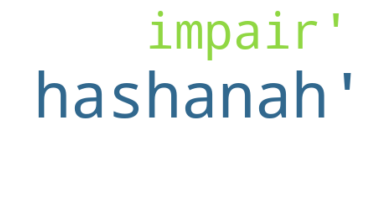


 Cluster 2:



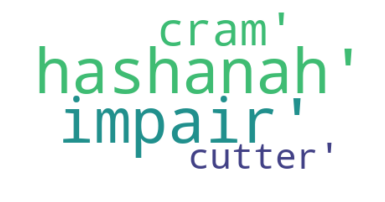


 Cluster 3:



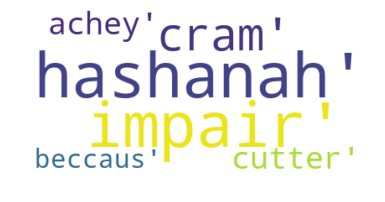


 Cluster 4:



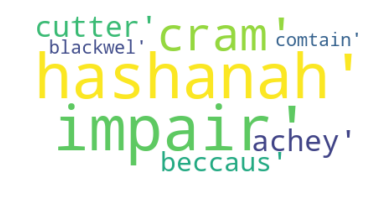


 Cluster 5:



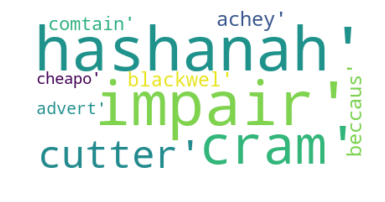


 Cluster 6:



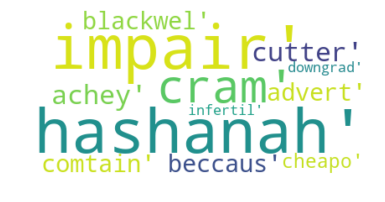


 Cluster 7:



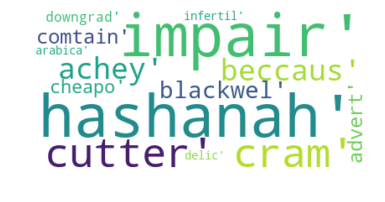


 Cluster 8:



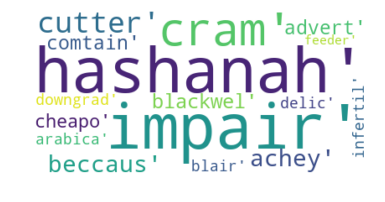


 Cluster 9:



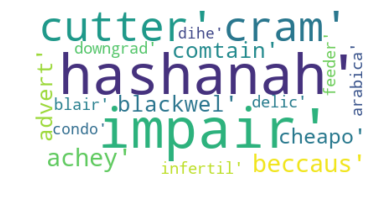


 Cluster 10:



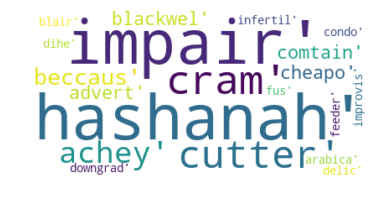


 Cluster 11:



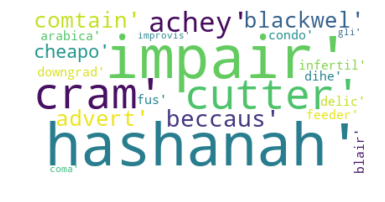


 Cluster 12:



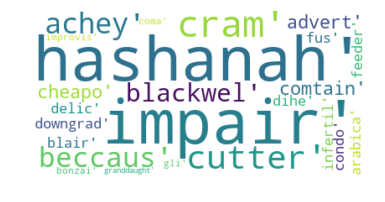


 Cluster 13:



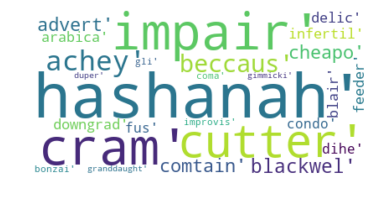


 Cluster 14:



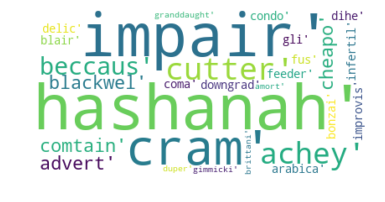


 Cluster 15:



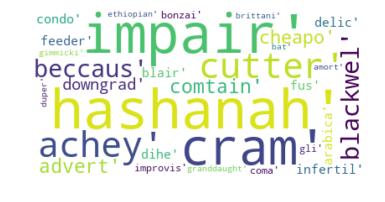


 Cluster 16:



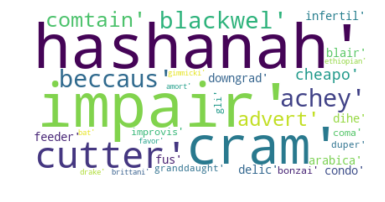


 Cluster 17:



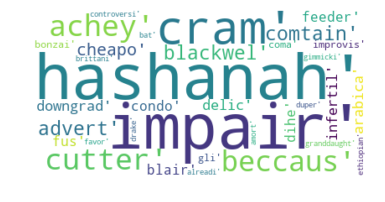


 Cluster 18:



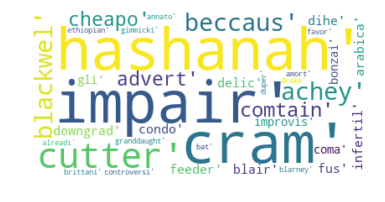


 Cluster 19:



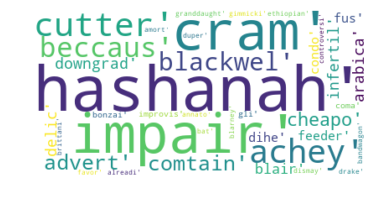

In [154]:
store = []
stop =  set(STOPWORDS)
for i in range(1,20):
    print("\n Cluster %d:\n" % i)
    for j in child[i, :10000]:
        store.append(terms[j])
        #print(' %s' % terms[j]),
    #print
   
    wc = WordCloud(background_color="white", stopwords=stop)
    wc.generate(str(store))
   # print("Word Cloud forCluster:", i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


# TF-IDF weighted Word2Vec:

In [155]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [156]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4375/4375 [00:03<00:00, 1095.37it/s]


In [157]:
for k in range(1, 20):
    model =  AgglomerativeClustering(n_clusters= k, affinity= 'euclidean').fit(tfidf_sent_vectors)
model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=19,
            pooling_func=<function mean at 0x7f2adc158598>)

In [158]:
child = model.children_
child

array([[3954, 4299],
       [1145, 2515],
       [  51,  706],
       ...,
       [8737, 8745],
       [8740, 8746],
       [8744, 8747]])

In [159]:
labels = model.labels_
labels

array([11,  6, 17, ..., 18,  5,  6])

In [161]:
terms = tfidf_feat



 Cluster 1:



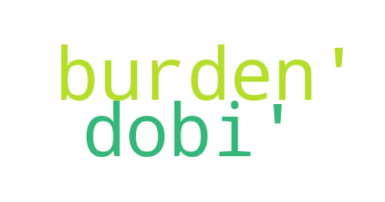


 Cluster 2:



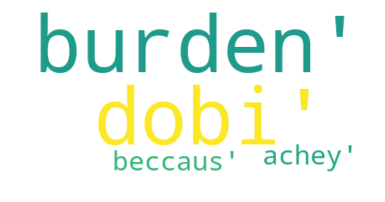


 Cluster 3:



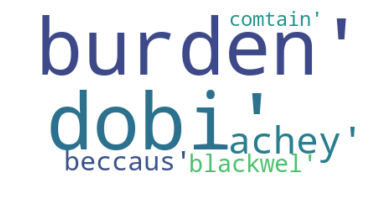


 Cluster 4:



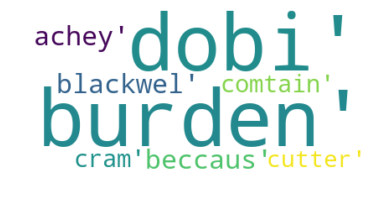


 Cluster 5:



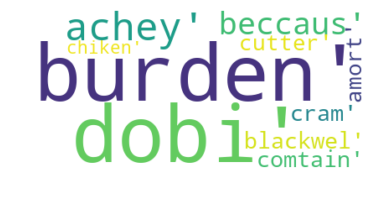


 Cluster 6:



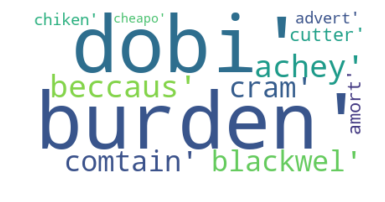


 Cluster 7:



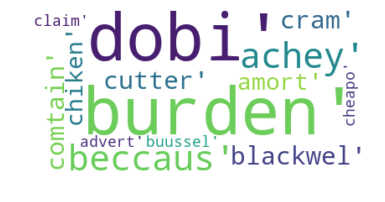


 Cluster 8:



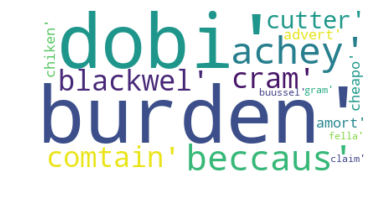


 Cluster 9:



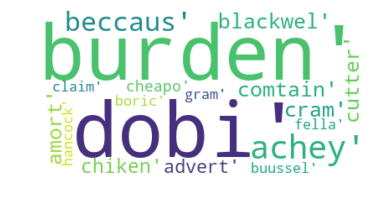


 Cluster 10:



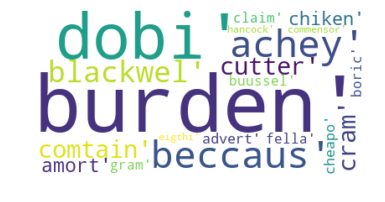


 Cluster 11:



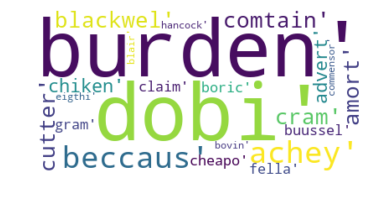


 Cluster 12:



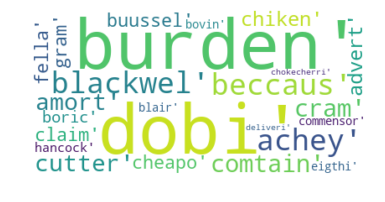


 Cluster 13:



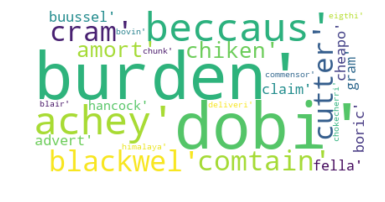


 Cluster 14:



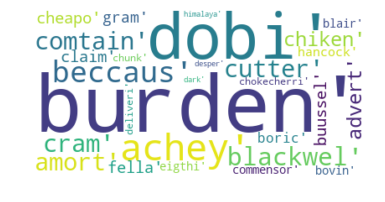


 Cluster 15:



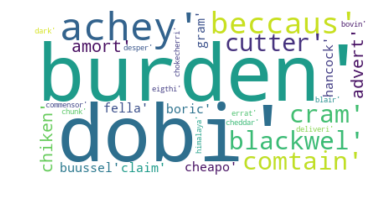


 Cluster 16:



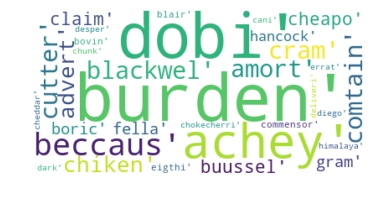


 Cluster 17:



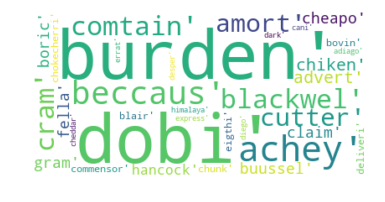


 Cluster 18:



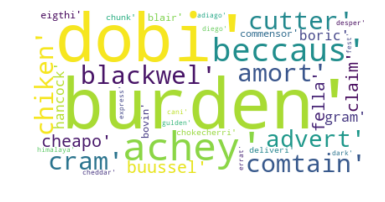


 Cluster 19:



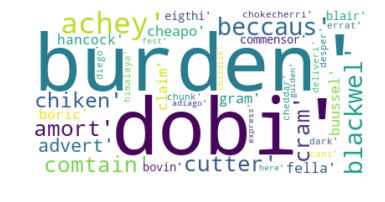

In [164]:
store = []
stop =  set(STOPWORDS)
for i in range(1,20):
    print("\n Cluster %d:\n" % i)
    for j in child[i, :10000]:
        store.append(terms[j])
        #print(' %s' % terms[j]),
    #print
   
    wc = WordCloud(background_color="white", stopwords=stop)
    wc.generate(str(store))
   # print("Word Cloud forCluster:", i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
